In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [18]:
# Read the Excel file into a DataFrame
df_train = pd.read_excel(r'acc_gyr.xlsx')

In [19]:
df_train.head()   #first 5 rows of the data

,xAcc,yAcc,zAcc,xGyro,yGyro,zGyro,label
0,6.99,-0.57,-7.28,-2.75,-3.23,2.62,fall
1,6.51,-0.75,-6.93,-0.67,-6.35,4.64,fall
2,6.22,-0.63,-6.73,0.79,-5.49,3.85,fall
3,6.34,-0.62,-6.80,1.59,-2.26,0.67,fall
4,6.49,-0.39,-6.60,0.67,-0.24,-1.10,fall


In [20]:
df_train.shape

(96800, 7)

In [21]:
df_train.isnull().sum()

xAcc     0
yAcc     0
zAcc     0
xGyro    0
yGyro    0
zGyro    0
label    0
dtype: int64

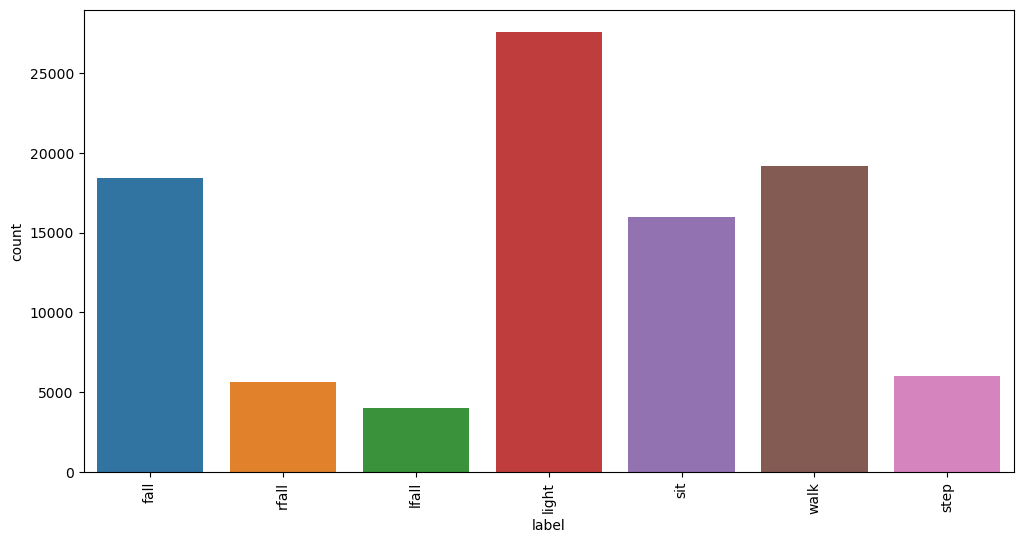

In [22]:
#Now Visualize the class Distribution

plt.figure(figsize=(12,6))
axis=sns.countplot(x="label",data=df_train)
plt.xticks(x=df_train['label'],rotation='vertical')
plt.show()

In [23]:
# Define the column and the string values to look for
column_to_delete_from = 'label'
values_to_match = ('fall', 'light', 'sit', 'walk')

# Define the proportion of rows to delete
proportion_to_delete = 0.7  # 70% of the matching rows

# Filter rows where the column matches any of the string values
matching_indices = df_train[df_train[column_to_delete_from].isin(values_to_match)].index

# Debugging: print the matching indices
print("\nMatching indices where column '{}' equals '{}':".format(column_to_delete_from, values_to_match))
print(matching_indices)

# Calculate the number of rows to delete
num_rows_to_delete = int(np.ceil(proportion_to_delete * len(matching_indices)))

# Debugging: print the number of rows to delete
print("\nNumber of rows to delete:", num_rows_to_delete)

# Check if there are rows to delete
if num_rows_to_delete > 0:
    # Randomly select indices from the matching indices
    indices_to_delete = np.random.choice(matching_indices, size=num_rows_to_delete, replace=False)

    # Debugging: print the indices to delete
    print("\nIndices to delete:")
    print(indices_to_delete)

    # Drop the selected rows
    df_train = df_train.drop(indices_to_delete)

# Print the modified DataFrame
print("\nDataFrame after randomly deleting rows where column '{}' equals '{}':".format(column_to_delete_from, values_to_match))
print(df_train)



Matching indices where column 'label' equals '('fall', 'light', 'sit', 'walk')':
Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       96790, 96791, 96792, 96793, 96794, 96795, 96796, 96797, 96798, 96799],
      dtype='int64', length=81201)

Number of rows to delete: 56841

Indices to delete:
[87219  5423 39943 ... 90298 58389 42378]

DataFrame after randomly deleting rows where column 'label' equals '('fall', 'light', 'sit', 'walk')':
        xAcc  yAcc  zAcc  xGyro  yGyro  zGyro  label
2       6.22 -0.63 -6.73   0.79  -5.49   3.85   fall
7       6.67 -1.01 -7.20  -5.31   5.37   0.98   fall
18      6.81  0.14 -7.16  -5.19   1.10  -2.32   fall
27      7.27 -0.33 -7.27  -1.46 -15.38  12.76   fall
31      6.74 -0.28 -6.51  -4.82 -13.12   9.03   fall
...      ...   ...   ...    ...    ...    ...    ...
96787  10.16 -2.97 -8.81  52.25   6.29 -37.23  light
96789   7.89  2.09 -3.63  37.66   4.46 -31.74  light
96796   7.39 -0.37 -5.05  20.08   0.06 -3

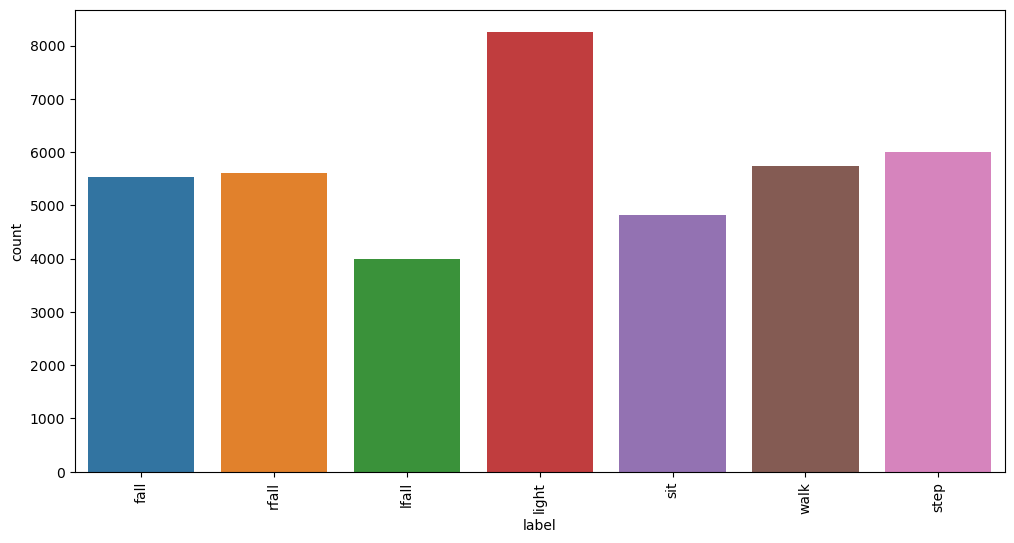

In [24]:
#Now Visualize the class Distribution

plt.figure(figsize=(12,6))
axis=sns.countplot(x="label",data=df_train)
plt.xticks(x=df_train['label'],rotation='vertical')
plt.show()

In [25]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
xAcc,39959.0,7.093269,3.120046,-39.24,5.62,6.90,8.290,39.24
yAcc,39959.0,-1.324625,3.118407,-39.24,-2.86,-1.20,0.395,39.24
zAcc,39959.0,-2.437019,5.796935,-35.14,-6.15,-4.64,-0.800,39.24
xGyro,39959.0,-1.155815,34.081666,-379.09,-12.82,-0.43,11.230,439.39
yGyro,39959.0,-0.651111,24.909725,-437.81,-6.29,0.24,6.990,304.32
zGyro,39959.0,0.028050,28.316764,-276.00,-11.05,-0.92,11.960,304.87


In [26]:
# Encode the labels
label_encoder = LabelEncoder()
df_train['label'] = label_encoder.fit_transform(df_train['label'])

# Scale the features
scaler = StandardScaler()
features = df_train[['xAcc', 'yAcc', 'zAcc', 'xGyro', 'yGyro', 'zGyro']]
features_scaled = scaler.fit_transform(features)

In [27]:
print(df_train['label'].unique())

[0 3 1 2 4 6 5]


In [28]:
# Prepare the sequences
def create_sequences(features, labels, seq_length=10):
    xs, ys = [], []
    for i in range(len(features) - seq_length):
        x_seq = features[i:i + seq_length]
        y_seq = labels.iloc[i + seq_length]
        xs.append(x_seq)
        ys.append(y_seq)
    return np.array(xs), np.array(ys)

seq_length = 10
X, y = create_sequences(features_scaled, df_train['label'], seq_length)

In [29]:
# Convert labels to one-hot encoding
y = to_categorical(y, num_classes=len(label_encoder.classes_))

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(seq_length, 6), return_sequences=True))
model.add(LSTM(64))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Save the model
model.save('fall_detection_model.keras')

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Model Accuracy: {accuracy*100:.2f}%")


C:\Users\THE LAPTOP SHOP\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
799/799 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.5068 - loss: 1.2670 - val_accuracy: 0.6916 - val_loss: 0.8148
Epoch 2/10
799/799 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.7174 - loss: 0.7448 - val_accuracy: 0.7445 - val_loss: 0.6657
Epoch 3/10
799/799 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.7621 - loss: 0.6190 - val_accuracy: 0.7705 - val_loss: 0.5911
Epoch 4/10
799/799 ━━━━━━━━━━━━━━━━━━━━ 15s 19ms/step - accuracy: 0.7974 - loss: 0.5212 - val_accuracy: 0.7991 - val_loss: 0.5187
Epoch 5/10
799/799 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.8213 - loss: 0.4553 - val_accuracy: 0.8257 - val_loss: 0.4685
Epoch 6/10
799/799 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - accuracy: 0.8481 - loss: 0.3989 - val_accuracy: 0.8364 - val_loss: 0.4241
Epoch 7/10
799/799 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.8706 - loss: 0.3411 - val_accuracy: 0.8498 - val_loss: 0.3806
Epoch 8/10
799/799 ━━━━━━━━━━━━━━━━━━━━ 14s 17ms/step - accuracy: 0.8786 - loss: 0.3149 - 

In [30]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Load the model
model = tf.keras.models.load_model('fall_detection_model.keras')

# Load the dataset for scaling and label encoding
data = pd.read_excel(r'acc_gyr.xlsx')

# Initialize the scaler and label encoder
scaler = StandardScaler()
scaler.fit(data[['xAcc', 'yAcc', 'zAcc', 'xGyro', 'yGyro', 'zGyro']])
label_encoder = LabelEncoder()
label_encoder.fit(data['label'])

def predict_sensor_data(readings):
    # Convert readings to a numpy array and scale
    readings_scaled = scaler.transform(np.array(readings).reshape(1, -1))

    # Create a sequence of length 10
    readings_seq = np.repeat(readings_scaled, 10, axis=0).reshape(1, 10, 6)

    # Predict using the model
    prediction = model.predict(readings_seq)
    predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])

    return predicted_label[0]

# Example sensor readings
example_readings = [4.62, 1.78, -5.1, -6.23, -11.84, 5.13]

# Get the prediction
predicted_label = predict_sensor_data(example_readings)
print(f"Predicted Label: {predicted_label}")


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
Predicted Label: step
